In [71]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, recall_score, precision_score
from sklearn.feature_extraction.text import TfidfVectorizer
import string
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.probability import FreqDist
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from textblob import TextBlob, Word
from imblearn.over_sampling import ADASYN
%matplotlib inline

from nltk.sentiment.vader import SentimentIntensityAnalyzer
import string
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer


In [87]:
df = pd.read_csv('nlp_farm_restaurant.csv', encoding='ISO-8859-1')
df.head()

,business_id,date,text,compliment_count
0,ZBtQ-Z8Eb66fJm4CUDoFTg,2016-08-09 19:38:51.000000 UTC,Amazing hot food that is also cheap.,0.0
1,ZBtQ-Z8Eb66fJm4CUDoFTg,2017-08-04 17:29:43.000000 UTC,Delicious food available for purchase. HUGE qu...,0.0
2,ZBtQ-Z8Eb66fJm4CUDoFTg,2016-03-08 17:52:18.000000 UTC,Flies in the meat counter and rude to go with it!,0.0
3,ZBtQ-Z8Eb66fJm4CUDoFTg,2016-03-08 17:51:25.000000 UTC,Flies in the meat counter; not the friendliest...,0.0
4,uz0Af3aczwENPY48UUEY0Q,2021-08-05 16:51:43.000000 UTC,Great time great food service was above Excellent,0.0


In [104]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/heyixuan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [59]:
# compliment_data = df[df["compliment_count"] == 1]
# compliment_data.to_csv("cd.csv", index=False)
# compliment_data
# cd = pd.read_csv("cd.csv")

# import pandas as pd
# from collections import Counter
# import re

# all_text = ' '.join(cd["text"].astype(str).tolist())

# words = re.findall(r'\b\w+\b', all_text.lower())

# word_counts = Counter(words)
# sorted_word_counts = sorted(word_counts.items(), key=lambda x: x[0].lower())

# output_file = "word_counts.txt"
# with open(output_file, "w") as file:
#     for word, count in sorted_word_counts:
#         file.write(f"{word}: {count}\n")

# print(f"Word counts saved to {output_file}")



## cleaning the text data with various operations
### To clean textual data, we call our custom ‘clean_text’ function that performs several transformations:lower the text

tokenize the text (split the text into words) and remove the punctuation
remove useless words that contain numbers
remove useless stop words like ‘the’, ‘a’ ,’this’ etc.
Part-Of-Speech (POS) tagging: assign a tag to every word to define if it corresponds to a noun, a verb etc. using the WordNet lexical database
lemmatize the text: transform every word into their root form (e.g. rooms -> room, slept -> sleep)
Now that we have cleaned our data, we can do some feature engineering for our modelization part.

In [105]:
from nltk.corpus import stopwords
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
import string
nltk.download('wordnet')


def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
df["text"] = df["text"].astype(str)

def clean_text(text):
    # lower text
    text = text.lower()
    # tokenize text and remove puncutation
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    # remove words that contain numbers
    text = [word for word in text if not any(c.isdigit() for c in word)]
    # remove stop words
    stop = stopwords.words('english')
    text = [x for x in text if x not in stop]
    # remove empty tokens
    text = [t for t in text if len(t) > 0]
    # pos tag text
    pos_tags = pos_tag(text)
    # lemmatize text
    lemmatizer = WordNetLemmatizer()
    text = [lemmatizer.lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
    # remove words with only one letter
    text = [t for t in text if len(t) > 1]
    # join all
    text = " ".join(text)
    return(text)

# clean text data
df["review_clean"] = df["text"].apply(lambda x: clean_text(x))


[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/heyixuan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [97]:
reviews_df = df.sample(frac = 0.1, replace = False, random_state=42)

In [93]:
# add number of characters column
df["nb_chars"] = df["text"].apply(lambda x: len(x))

# add number of words column
df["nb_words"] = df["text"].apply(lambda x: len(x.split(" ")))

## Feature engineering

we add some simple metrics for every text:
number of characters in the text
number of words in the text

The next step consist in extracting vector representations for every review. The module Gensim creates a numerical vector representation of every word in the corpus by using the contexts in which they appear (Word2Vec). This is performed using shallow neural networks. What’s interesting is that similar words will have similar representation vectors.

Each text can also be transformed into numerical vectors using the word vectors (Doc2Vec). Same texts will also have similar representations and that is why we can use those vectors as training features.

We first have to train a Doc2Vec model by feeding in our text data. By applying this model on our reviews, we can get those representation vectors.

In [94]:

# create doc2vec vector columns
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

In [95]:
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(df["review_clean"].apply(lambda x: x.split(" ")))]

# train a Doc2Vec model with our text data
model = Doc2Vec(documents, vector_size=5, window=2, min_count=1, workers=4)

# transform each document into a vector data
doc2vec_df = df["review_clean"].apply(lambda x: model.infer_vector(x.split(" "))).apply(pd.Series)
doc2vec_df.columns = ["doc2vec_vector_" + str(x) for x in doc2vec_df.columns]
review_df = pd.concat([df, doc2vec_df], axis=1)

## TF-IDF

Finally we add the TF-IDF (Term Frequency — Inverse Document Frequency) values for every word and every document.

But why not simply counting how many times each word appears in every document? The problem with this method is that it doesn’t take into account the relative importance of words in the texts. A word that appears in almost every text would not likely bring useful information for analysis. On the contrary, rare words may have a lot more of meanings.

The TF-IDF metric solves this problem:

TF computes the classic number of times the word appears in the text
IDF computes the relative importance of this word which depends on how many texts the word can be found
We add TF-IDF columns for every word that appear in at least 10 different texts to filter some of them and reduce the size of the final output.



In [98]:
# add tf-idfs columns
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(min_df = 10)
tfidf_result = tfidf.fit_transform(reviews_df["review_clean"]).toarray()
tfidf_df = pd.DataFrame(tfidf_result, columns = tfidf.get_feature_names_out())
tfidf_df.columns = ["word_" + str(x) for x in tfidf_df.columns]
tfidf_df.index = reviews_df.index
reviews_df = pd.concat([reviews_df, tfidf_df], axis=1)

In [99]:
reviews_df["compliment_count"].value_counts(normalize = True)

compliment_count
0.0    0.981651
1.0    0.013761
2.0    0.004587
Name: proportion, dtype: float64

In [79]:

from wordcloud import WordCloud

## wordcloud

Now print some wordclouds to have a glimpse at what kind of words apear in our reviews:

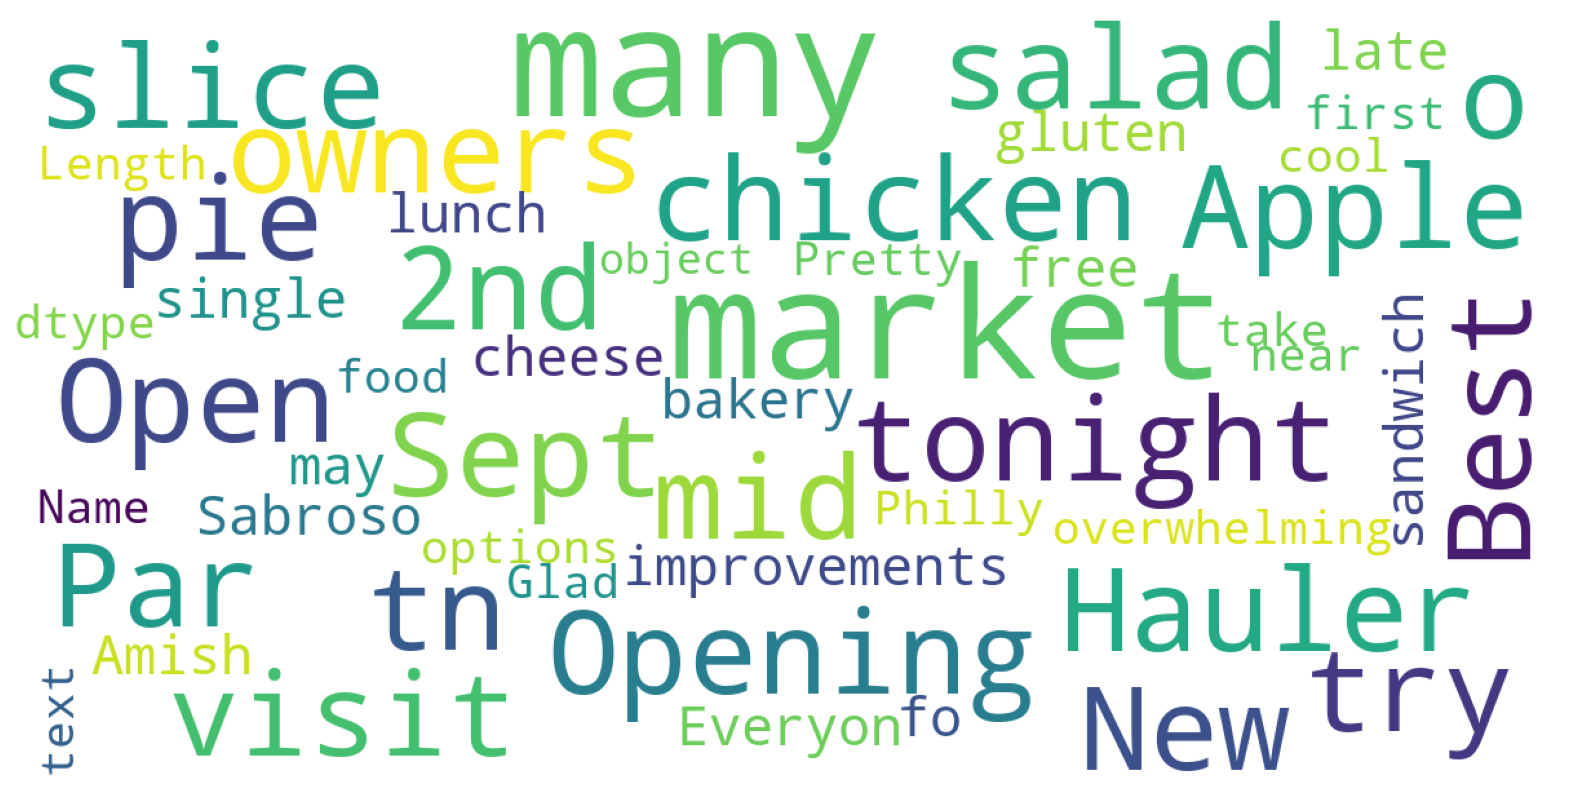

In [100]:

import matplotlib.pyplot as plt

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color = 'white',
        max_words = 200,
        max_font_size = 40, 
        scale = 3,
        random_state = 42
    ).generate(str(data))

    fig = plt.figure(1, figsize = (20, 20))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize = 20)
        fig.subplots_adjust(top = 2.3)

    plt.imshow(wordcloud)
    plt.show()
    
# print wordcloud
show_wordcloud(reviews_df["text"])


In [ ]:
reviews_df

,user_id,business_id,text,date,compliment_count,review_clean,nb_chars,nb_words,word_abita,word_able,...,word_yuck,word_yum,word_yumm,word_yummm,word_yummmm,word_yummmmm,word_yummy,word_yup,word_zero,word_zucchini
20895,BV3de4sPoZ89vbaqb1XMNw,nYsNsyIppe_DTueBha1x9A,"A local staple, vegetarians beware the black b...",2019-01-31 00:48:40,0,local staple vegetarian beware black bean cook...,72,12,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
71962,TJLv7q47JlWaD3ri20n6Lg,Hi2ADMI1_BEahkXRP4lcjg,Pasta is thick and cheap. Pretty restaurant at...,2013-03-03 04:53:10,0,pasta thick cheap pretty restaurant atmosphere...,235,44,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
301195,vRp6jlO9M6wLi150CvX6Ig,4nDVM0XqWrcKQbMYlXDWCg,Now with three St. Louis made penny-farthing b...,2017-05-19 15:54:47,0,three st louis make penny-farthing bike displa...,171,32,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
375173,vnl8aTXiLC08mVtG5Tu_xw,RwOV1rfT7vA1qw8vgf-yBA,Get the Turkey Jack!,2010-02-15 00:47:00,0,get turkey jack,20,4,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
44461,URW80hbqt4f7nIuT1y1dTA,kyRUZEZThKotuabJQfuXYA,Cute atmosphere with great food,2016-06-17 00:34:38,0,cute atmosphere great food,31,5,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
366416,EOP0U2jAsJHrAqrU2bXBFg,MYZuMWSZ9-1q-_1fbWfvow,Good food,2020-09-05 21:50:31,0,good food,9,2,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
97681,3SWkkkWMNzV1Nws3oZCwKQ,eZm0-iedpPrumpf_4eeJag,Vegetable soup!,2012-11-12 17:08:07,0,vegetable soup,15,2,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
453919,YNh4pFBa88NA2zUiHqBLqw,cBp1fn2LXpSHe4VbTXLYEw,WiFi password is on your receipt,2017-11-10 19:12:43,0,wifi password receipt,32,6,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
280601,AOL0kZklABRH-TR3QD7yXw,FEXhWNCMkv22qG04E83Qjg,"To go line in the back, if you don't want to w...",2014-06-20 15:38:11,0,go line back want wait table,61,15,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
